## Probability rescaling

In Atomica, there are two key conversions for probabilities

1. Converting between (mean) durations and probabilities - for example, when users enter a treatment duration, this needs to be converted into a probability of leaving the treatment compartment due to treatment completion
2. Converting probabilities when the time step changes. For a fixed underlying rate, the probability of making a transition increases with time. Probabilities therefore need to be adjusted when the timestep changes to preserve the model's behaviour, and to converge to a prediction in the limit of small step sizes. 

This page provides some examples of how probability scaling works under different circumstances

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First, consider the most technically accurate case - we have a continuous time setup with discrete agents, with two compartments

$$
\rightarrow c_1 \rightarrow c_2 \rightarrow
$$

where people enter $c_1$ at a fixed rate. The average time spent in $c_1$ and $c_2$ is known. Suppose we simulate the arrival of the agents in the system, and sample the duration of time spent by each agent in each state from an appropriate probability distribution. If we inspect the system at a snapshot in time, how many people do we expect to find in each compartment?

In reality, we often work with durations that obey distributions qualitatively similar to a normal distribution - for example, a treatment duration might be 3 months, with some symmetric distribution around that mean. Sampling the duration from a normal distribution yields:

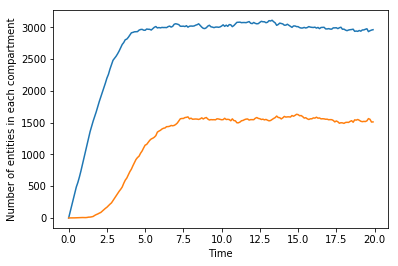

In [23]:
dur1 = 3
dur2 = 1.5
n_agents_per_year = 1000
n_years = 20

# Assume arrivals follow a Poisson process with an inter-arrival period set to match the number of people
# expected per year i.e. 1/1000 years between arrivals on average
arrival_time = np.cumsum(np.random.exponential(1/n_agents_per_year,(n_agents_per_year*n_years,1))).ravel() 
# Sample the time spent in the first compartment
t1 = np.maximum(0,np.random.randn(n_agents_per_year*n_years,1).ravel()+dur1) 
# Sample the time spent in the second compartment
t2 = np.maximum(0,np.random.randn(n_agents_per_year*n_years,1).ravel()+dur2)

def get_agents(t):
    # How many agents are present at time t
    agents_in_c1 = (arrival_time< t) & ((arrival_time + t1) > t)
    agents_in_c2 = ((arrival_time + t1) < t) & ((arrival_time + t1 + t2) > t)
    return sum(agents_in_c1), sum(agents_in_c2)

probe = np.arange(0,20,0.1)
z = np.array(list(map(get_agents,probe)))
plt.plot(probe,z);
plt.xlabel('Time');
plt.ylabel('Number of entities in each compartment');

This is the most realistic case, where durations are modelling most accurately. Notice how the number of people in $c_1$ linearly increases for the first 3 years, because nobody has started to leave yet. Similarly, it takes some time before people start arriving in $c_2$. On the other hand, in the model, where we work with Markov processes and state transitions behave as Poisson processes, we would typically be sampling from an exponential distribution.

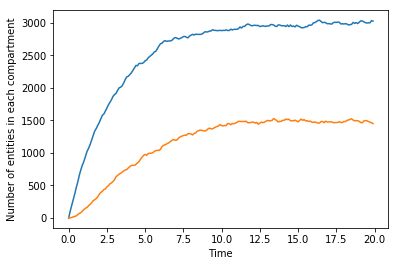

In [24]:
dur1 = 3
dur2 = 1.5
n_agents_per_year = 1000
n_years = 20

arrival_time = np.cumsum(np.random.exponential(1/n_agents_per_year,(n_agents_per_year*n_years,1))).ravel() 
t1 = np.random.exponential(dur1,(n_agents_per_year*n_years,1)).ravel() 
t2 = np.random.exponential(dur2,(n_agents_per_year*n_years,1)).ravel() 

def get_agents(t):
    # How many agents are present at time t
    agents_in_c1 = (arrival_time< t) & ((arrival_time + t1) > t)
    agents_in_c2 = ((arrival_time + t1) < t) & ((arrival_time + t1 + t2) > t)
    return sum(agents_in_c1), sum(agents_in_c2)

probe = np.arange(0,20,0.1)
z = np.array(list(map(get_agents,probe)))
plt.plot(probe,z);
plt.xlabel('Time');
plt.ylabel('Number of entities in each compartment');

Now, people immediately start flowing from $c_1$ to $c_2$ so the system converges to its steady state with dynamics that are different to the model with normally-distributed durations. However, the end result is the same.

Note that this is a proper continuous system - we have imposed no constraints as to when transitions can occur, so the idea is that the figures above are what our discrete system should approximate, subject to conditions like sufficiently small time steps (and indeed, we would expect that the steady state solution above is converged to in the limit of small time steps).

Suppose then that we are setting up a discrete system of ODEs an an approximation to this system (i.e. moving from an agent-based model to a compartment model). First, we implement a basic Euler-type solver to integrate an ODE, defined by the `rhs` function which returns the derivative

In [25]:
def euler(rhs,x,tspan,dt):
    t = np.arange(tspan[0],tspan[1],dt)
    x = np.array(x).ravel().reshape(-1,1)
    y = np.zeros((x.size,t.size))
    y[:,0] = x.ravel()
    for i in range(0,t.size-1):
        y[:,i+1] = y[:,i] + rhs(y[:,i],t[i])
    return t,y

Note that the stepping in this integrator is governed by `y[:,i+1] = y[:,i] + rhs(y[:,i],t[i])` _not_ `y[:,i+1] = y[:,i] + dt*rhs(y[:,i],t[i])`.
That is, the RHS function is returning a number of people to transfer at each time step (e.g. `dx`), not per unit time (e.g. `dx/dt`). This matches the integration setup in Atomica, where we compute the flow values at each time step, rather than the flow rate. 

The setup is now framed in terms of transition probabilities, so our system of ODEs has

- A first stage, where people have a probability of departure of $p_1$ per year
- A second stage, where people have a probability of departure of $p_2$ per year
- A constant inflow $a$ of 1000 people/year

And we will consider various ways of obtaining the values for $p_1$ and $p_2$ that are required in order to match the numerical examples above. So our system of ODEs can be written as:

$$
\frac{dc_1}{dt} = a - p_1c_1\\
\frac{dc_c}{dt} = p_1c_1 - p_2c_2
$$

First, suppose we use the Poisson based calculation to convert from duration to probability in a continuous fashion. This formulation is as follows - for a Poisson process, the time between events is governed by an exponential distribution 

$$
P(t) = \lambda e^{-\lambda t}
$$

where $P$ is the probability of an event occuring at time $t$, and the rate parameter $\lambda$ is the reciprocal of the mean time between events. We can ask what the probability is of at least one event being encountered over a period of time by integrating this distribution. The exponential CDF is

$$
F(t) = 	1 − e^{-\lambda t}
$$

where $F$ is the probability of at least one event occuring by time $t$. So, we compute the probability of a transition taking place during a timestep by evaluating the CDF with the size of the timestep. For example, the annual probabilities corresponding to the durations specified are:

In [26]:
print('1/3 -> %.4f' % (1.0 - np.exp(-1/3)))
print('1/1.5 -> %.4f' % (1.0 - np.exp(-1/1.5)))

1/3 -> 0.2835
1/1.5 -> 0.4866


Ratio of steady state compartments: 1.4634


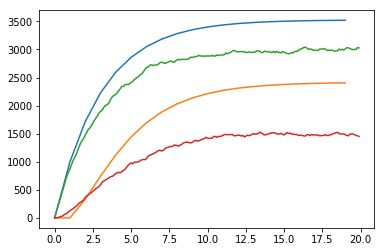

In [27]:
def rhs(x,t):
    dx = np.zeros(2)
    dx[0] = 1000-(0.2835)*x[0]
    dx[1] = (1/3)*x[0] - (0.4866)*x[1]
    return dx

t,y = euler(rhs,[0,0],[0,20],1)
plt.plot(t,y.T);
plt.plot(probe,z);
print('Ratio of steady state compartments: %.4f' % (y[:,-1][0]/y[:,-1][1]))

However, we can see that this clearly does not approach the same limit as the continuous agent-based calculation. 

As an alternate approach, the discrete steps of the Euler integrator mean that transitions between compartments can be treated as a Bernoulli process, with a fixed probability of success at each time, and the duration spent in each compartment would then follow a geometric distribution. The mean of a geometric distribution is simply $1/p$ where $p$ is the transition probability. In this conceptualization, the appropriate probabilities to use would be $p_1=1/3$ and $p_2=1/1.5$. Using these values yields:

Ratio of steady state compartments: 2.0009


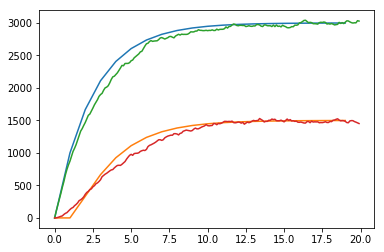

In [28]:
def rhs(x,t):
    dx = np.zeros(2)
    dx[0] = 1000-(1/3)*x[0]
    dx[1] = (1/3)*x[0] - (1/1.5)*x[1]
    return dx

t,y = euler(rhs,[0,0],[0,20],1)
plt.plot(t,y.T);
plt.plot(probe,z);
print('Ratio of steady state compartments: %.4f' % (y[:,-1][0]/y[:,-1][1]))

We could analytically solve to find the steady state solution, which is

$$
a = p_1c_1\\
c_1 = \frac{a}{p_1}
$$

and

$$
p_1c_1 = p_2c_2\\
c_2 = \frac{c_1p_1}{p_2}
$$


which for the given values of $a$, $p_1$ and $p_2$ yields

$$
c_1 = \frac{100}{0.25} = 400\\
c_2 = \frac{400 \times 0.25}{0.5} = 200
$$

So we can confirm this steady state solution analytically. Notice that the ratios of the transition probabilities are the same as the ratios of the compartment sizes. 

Now, consider what happens if we change to quarterly timesteps. We would have to multiply the constant inflow by the timestep, and rescale the probabilities accordingly. In considering the outflow, if there was no inflow, the number of people remaining in the compartment in the model after a discrete number of steps is governed by the geometric distribution. That is, with the system of ODEs, it is given by $x_k = x_0p^k$ where $x_0$ is the initial number of people, and $k$ is the number of time steps. 

Now, consider rescaling this probability as we move to a smaller timestep - say, 0.25 years. Using the duration to probability conversion directly yields:


In [8]:
print('1/3 -> %.4f' % (1.0 - np.exp(-0.25/3)))
print('1/1.5 -> %.4f' % (1.0 - np.exp(-0.25/1.5)))

1/3 -> 0.0800
1/1.5 -> 0.1535


So, when we substitute these values in, we get

Ratio of steady state compartments: 1.9216


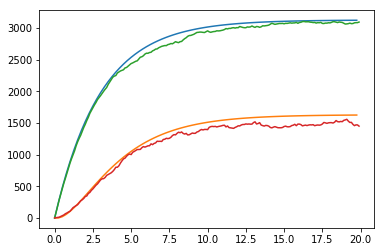

In [9]:
def rhs(x,t):
    dx = np.zeros(2)
    dx[0] = 1000*0.25-0.0800*x[0]
    dx[1] = 0.0800*x[0] - 0.1535*x[1]
    return dx

t1,y1 = euler(rhs,[0,0],[0,20],0.25)
plt.plot(t1,y1.T);
plt.plot(probe,z);
print('Ratio of steady state compartments: %.4f' % (y1[:,-1][0]/y1[:,-1][1]))

This is somewhat better than before, so this approach exhibits the correct limiting behaviour as the step size becomes very small. If we use the geometric calculation's annual probabilies, but the traditional formula to convert from annual to timestep probabilities, we get:

In [10]:
convert = lambda p, dt: 1. - (1. - p)**dt
print('1/3 -> %.4f' % convert(1/3,0.25))
print('1/1.5 -> %.4f' % convert(1/1.5,0.25))

1/3 -> 0.0964
1/1.5 -> 0.2402


Ratio of steady state compartments: 2.4923


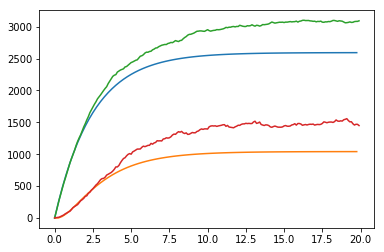

In [11]:
def rhs(x,t):
    dx = np.zeros(2)
    dx[0] = 1000*0.25-0.0964*x[0]
    dx[1] = 0.0964*x[0] - 0.2402*x[1]
    return dx

t1,y1 = euler(rhs,[0,0],[0,20],0.25)
plt.plot(t1,y1.T);
plt.plot(probe,z);
print('Ratio of steady state compartments: %.4f' % (y1[:,-1][0]/y1[:,-1][1]))

The problem with this case is that the simulation at step size 1 with these probabilities looked fine, yet at `dt=0.1` the results are now very different. This suggests that the conversion `1. - (1. - p)**dt` does not preserve the steady state limit. This is clearly the case because that conversion is a nonlinear transformation, which will change the ratio of $p_1$ to $p_2$ and thus change the steady state solution as well. 

On the other hand, with the geometric distribution based conversion, we would use the linear transformation:

In [12]:
convert = lambda p, dt: p*dt
print('1/3 -> %.4f' % convert(1/3,0.25))
print('1/1.5 -> %.4f' % convert(1/1.5,0.25))

1/3 -> 0.0833
1/1.5 -> 0.1667


Ratio of steady state compartments: 2.0033


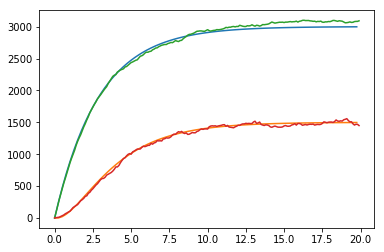

In [13]:
def rhs(x,t):
    dx = np.zeros(2)
    dx[0] = 1000*0.25-0.0833*x[0]
    dx[1] = 0.0833*x[0] - 0.1667*x[1]
    return dx

t2,y2 = euler(rhs,[0,0],[0,20],0.25)
plt.plot(t2,y2.T);
plt.plot(probe,z);
print('Ratio of steady state compartments: %.4f' % (y2[:,-1][0]/y2[:,-1][1]))

so we continue to converge to the correct continuous-time solution. Indeed, with the smaller timestep, with the smaller step we achieve a closer match to the continuous-time case. 

It is worth noting that we do expect the Poisson duration calculation to converge to the geometric calculation, because the duration conversion from the Poisson distribution `P = (1.0 - np.exp(-dt/dur)))` and the geometric conversion with `P = dt/dur` have the same limit for small `dt`. Consider the series expansion of $e^x$ which is

$$
e^x \approx \frac{x^0}{0!} + \frac{x^1}{1!} + \frac{x^2}{2!} + \cdots
$$

As `dt` becomes small, we can discard the higher order terms in the series, and retaining only the first two terms, we obtain

$$
e^x \approx 1 - x
$$

And so we find that `1.0 - np.exp(-dt/dur))` approaches `dt/dur` for small `dt`.

### Geometric vs Exponential distribution for durations

Certainly the fact that Poisson-based duration conversion `P = (1.0 - np.exp(-dt/dur)))` has the correct behaviour for small step sizes suggests that this approach could validly be used in the case where the step size is very small. But why does it perform so poorly for small durations? Or more specifically, durations that are similar to the step size? Consider what happens in the case where we have a mean duration that is exactly the same as the simulation timestep. With discrete simulation timesteps, we _enforce_ that the minimum time spent in a state is one timestep. So when computing the time taken to empty the compartment, if anyone takes longer than one timestep, the mean time taken to transition must necessarily be higher than 1. The timestep imposes a minimum value for the mean duration. However, if `dt=dur` then `(1.0 - np.exp(-dt/dur)))` means that only 63% of people make the transition in the first timestep. So the mean time taken to leave the compartment is significantly overestimated due to the large step size. If we consider a short duration, like 0.25 years, in the continuous case:

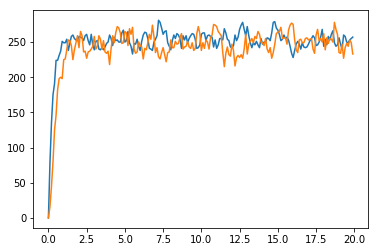

In [14]:
dur1 = 0.25
dur2 = 0.25
n_agents_per_year = 1000
n_years = 20

arrival_time = np.arange(0,n_agents_per_year*n_years)/n_agents_per_year # This is when the agent enters the first compartment
t1 = np.random.exponential(dur1,(n_agents_per_year*n_years,1)).ravel() # This is how long the agent spends in the first compartment
t2 = np.random.exponential(dur2,(n_agents_per_year*n_years,1)).ravel() # This is how long the agent spends in the second compartment

def get_agents(t):
    # How many agents are present at time t
    agents_in_c1 = (arrival_time< t) & ((arrival_time + t1) > t)
    agents_in_c2 = ((arrival_time + t1) < t) & ((arrival_time + t1 + t2) > t)
    return sum(agents_in_c1), sum(agents_in_c2)

probe = np.arange(0,20,0.1)
z = np.array(list(map(get_agents,probe)))
plt.plot(probe,z);

The analogous geometric probability system would have a transition probability of 1 at each timestep, not 0.63. Although this means that the compartment is emptied at every timestep, it also implies that the mean duration is correctly captured. Indeed, with a transition probability of 1, we recover the correct steady state solution:

Ratio of steady state compartments: 1.0000


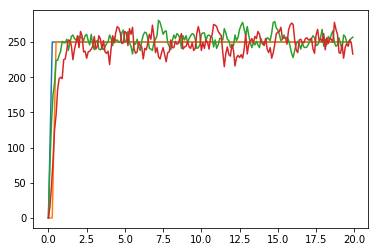

In [15]:
def rhs(x,t):
    dx = np.zeros(2)
    dx[0] = 1000*0.25-(0.25/0.25)*x[0]
    dx[1] = (0.25/0.25)*x[0] - (0.25/0.25)*x[1]
    return dx

t2,y2 = euler(rhs,[0,0],[0,20],0.25)
plt.plot(t2,y2.T);
plt.plot(probe,z);
print('Ratio of steady state compartments: %.4f' % (y2[:,-1][0]/y2[:,-1][1]))

But if we use the Poisson-derived value of 0.63, as with the other examples, we get a different solution:

Ratio of steady state compartments: 1.0000


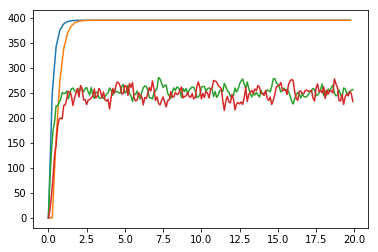

In [16]:
def rhs(x,t):
    dx = np.zeros(2)
    dx[0] = 1000*0.25-(1.0 - np.exp(-1))*x[0]
    dx[1] = (1.0 - np.exp(-1))*x[0] - (1.0 - np.exp(-1))*x[1]
    return dx

t2,y2 = euler(rhs,[0,0],[0,20],0.25)
plt.plot(t2,y2.T);
plt.plot(probe,z);
print('Ratio of steady state compartments: %.4f' % (y2[:,-1][0]/y2[:,-1][1]))

### Preserving durations vs preserving annual flows

Part of the motivation for the original timestep conversion was to preserve the annual flow. For instance, suppose there were 100 people in a compartment, and an annual transition probability of 0.6. This would mean that in the first timestep, 60 people would transition out of the compartment. If we had a timestep of 0.25 and use the conversion `P = 1-(1-0.6)**0.25 = 0.204` then the number of people remaining after 4 timesteps would be `100*(1-0.204)^4 = 40`. So, that conversion preserved the expected number of people that would flow out. Of course, this is only correct in the absence of any inflows. Because people that flow in are not eligible to leave the compartment in the same timestep, if we had an annual inflow of 100 people, with `dt=1` there would be `100*(1-0.6)+100 = 140` people in the compartment. Whereas with the flow-preserving conversion, we would have `((100*(1-0.204)+25)*(1-0.204)+25)... = 113.2` so already the presence of any inflows suggests that the predicted compartment sizes under this approximation will not remain the same as the step size is changed. That said, the same is true for the geometric conversion. The difference in the two methods is that while the Poisson conversion preserves neither the annual flow nor the steady state equilibrium, the geometric conversion does preserve the latter.

Another issue with the flow-preserving conversion is that it is not duration-preserving. To see this, consider that the converted probability is being chosen such that applying it some _discrete_ number of times yields the same annual probability. In other words, the cumulative _geometric_ distribution is equal in the two cases. The geometric CDF is

$$
F(k) = 1-(1-p)^k
$$

where $k$ is the number of steps, and $p$ is the probability at each step. We are setting it so that a timestep probability $p_2$ has the same annual probability $p_1$ for some $k>1$. Specifically:

$$
1-(1-p_2)^{k} = 1-(1-p_1)\\
p_2 = (1-p_1)^{1/k}
$$

where $k$ is the number of steps per year e.g. if `dt=0.25` then `k=4`. Clearly $p_2 \neq p_1/k$ but the mean number of samples (the mean of the geometric distribution) is `1/p`, so if both distributions had the same mean, then we would require $p_2 = p_1/k$. Preserving the annual flow (under the no-inflow approximation) is exclusive of preserving the duration even with no inflows. 

Finally, an argument for the geometric scaling can be made based on the probabilities in the steady state. In equilibrium, a compartment contains people that are uniformly distributed over time spent in the compartment. For example, with annual timesteps, in a compartment with a duration of 4 years, 25% of the compartment would be eligible to transition out at the next timestep. Thus, at each timestep, we should move `0.25` of the compartment. If the timestep was quarterly, then 1/16th of the compartment would be due to transition out at the next timestep, so the transition fraction should be `0.0625`. This corresponds to the mean of the distribution for a geometric distribution, which is the operation that is actually performed by the model. 

### Atomica models

Ultimately, the test is that we would expect that models in Atomica should give the same results when run at different step sizes (once the timestep is sufficiently small).

In [17]:
import sys
sys.path.append('..')
import atomica as at
at.logger.setLevel('ERROR')

def test_dt(dt,plot_pops=None):
    P.settings.update_time_vector(dt=dt)
    res = P.run_sim('default',result_name='dt=%.3f' % (dt))
    if plot_pops:
        d = at.PlotData(res,pops=plot_pops)
        at.plot_series(d,plot_type='stacked')
        plt.title('Timestep %.3f years' % dt)
    return res

Atomica 1.0.14 (2018-11-20) -- (c) the Atomica development team
2018-11-22 08:06:37.779846
git branch: timestep-conversions (c469427)


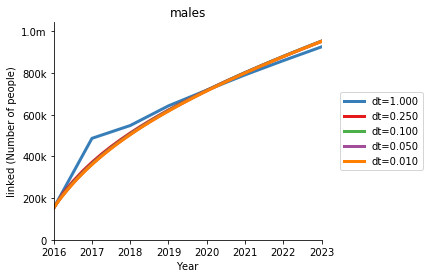

In [18]:
P = at.demo('hiv',do_run=False)
pops = 'males'
res = []
res.append(test_dt(1.0))
res.append(test_dt(0.25))
res.append(test_dt(0.1))
res.append(test_dt(0.05))
res.append(test_dt(0.01))
outputs = 'linked'
d = at.PlotData(res,outputs=outputs,pops=pops)
figs = at.plot_series(d,axis='results');

For this HIV example, convergence is rapid and the simulation remains qualitatively correct even for very large step sizes.

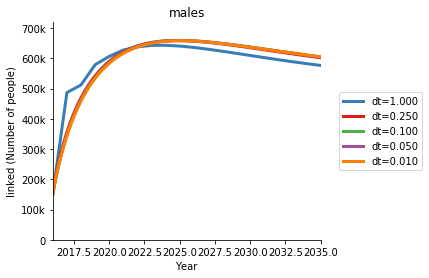

In [19]:
P = at.demo('hiv_dyn',do_run=False)
pops = 'males'
res = []
res.append(test_dt(1.0))
res.append(test_dt(0.25))
res.append(test_dt(0.1))
res.append(test_dt(0.05))
res.append(test_dt(0.01))
outputs = 'linked'
d = at.PlotData(res,outputs=outputs,pops=pops)
figs = at.plot_series(d,axis='results');

Similar results are observed with the HIV dynamic model

In [20]:
P = at.demo('tb',do_run=False)
pops = '0-4'
res = []
res.append(test_dt(1.0))
res.append(test_dt(0.25))
res.append(test_dt(0.1))
res.append(test_dt(0.05))
res.append(test_dt(0.01))

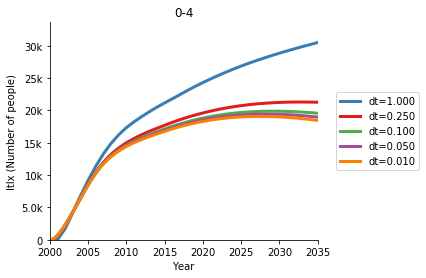

In [21]:
outputs = 'ltlx'
d = at.PlotData(res,outputs=outputs,pops=pops)
figs = at.plot_series(d,axis='results');

For TB, convergence is somewhat slower, but just switching from annual to quarterly timesteps provides a large improvement.

### Conclusions

Model integration is ultimately discrete, so in that sense it's logical to use the geometric distribution to consider converting durations to timestep probabilities or converting probabilities between timestep sizes. While this results in different flow rates to the previous conversions, it appears to do a better job of preserving durations, provides more consistent results when changing the step size, and preserves the system's equilibrium solution when changing the step size.